In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
from anndata import AnnData
import sys
import pickle
import os
sys.path.insert(1, '../')
import util
from itertools import product

# autoreload
%load_ext autoreload
%autoreload 2

# 
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

/home/jz286/myenv/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


In [2]:
# Data path
DATA_PATH = '/n/groups/price/martin/tms_gene_data'
DGE_RES_PATH = DATA_PATH + '/DGE_result'
DGE_RES_PATH_OLD = DATA_PATH + '/DE_result_old'

### bulk data

In [3]:
# Load original results 
with open(DGE_RES_PATH_OLD+'/DE_bulk.pickle', 'rb') as handle:
    dic_res_old = pickle.load(handle)
    analysis_list_old = pickle.load(handle)
    analysis_info_old = pickle.load(handle)

df_info,dic_res = util.load_DGE_res(DATA_PATH, dname='bulk.tissue')

In [4]:
# compare
analysis_list = list(df_info.index)
print('new reuslt only:', set(analysis_list) - set(analysis_list_old))
print('old reuslt only:', set(analysis_list_old) - set(analysis_list))
print('')
temp_list = list(set(analysis_list) & set(analysis_list_old))
temp_list.sort()
for i_tissue,tissue in enumerate(temp_list):
    
    n_dif_young = df_info.loc[tissue, 'n_sample_young'] - analysis_info_old[tissue]['n_young']
    n_dif_old = df_info.loc[tissue, 'n_sample_old'] - analysis_info_old[tissue]['n_old']
    
    # comparing the DGE results 
    gene_list = dic_res[tissue].index
    gene_list_old = dic_res_old[tissue].index
    gene_list_common = list(set(gene_list) & set(gene_list_old))
    temp_df = dic_res[tissue].loc[gene_list_common]
    temp_df_old = dic_res_old[tissue].loc[gene_list_common]

    v_coef = np.array(temp_df['age.logFC']) 
    v_nan_coef = np.isnan(v_coef)
    v_coef_old = np.array(temp_df_old['coef']) 
    v_nan_coef_old = np.isnan(v_coef_old)
    ind_select = (~v_nan_coef) & (~v_nan_coef_old)
    v_coef = v_coef[ind_select]
    v_coef_old = v_coef_old[ind_select]
    r_coef = np.absolute(v_coef - v_coef_old)/ (np.absolute(v_coef_old).clip(min=1e-8))

    v_raw_p = np.array(temp_df['age.H_p']) 
    v_nan_raw_p = np.isnan(v_raw_p)
    v_raw_p_old = np.array(temp_df_old['raw-p']) 
    v_nan_raw_p_old = np.isnan(v_raw_p_old)
    ind_select = (~v_nan_raw_p) & (~v_nan_raw_p_old)
    v_raw_p = v_raw_p[ind_select]
    v_raw_p_old = v_raw_p_old[ind_select]
    r_raw_p = np.absolute(v_raw_p - v_raw_p_old)/ (np.absolute(v_raw_p_old).clip(min=1e-8))


    # tell if the results are the same 
    flag_dif = (n_dif_young==0) & (n_dif_old==0) & \
                (np.quantile(r_coef, 0.99)<1e-4) & (np.quantile(r_raw_p, 0.99)<1e-4)
    
    if flag_dif==False:
        print('%d/%d, %s, n_gene=%d, n_gene_old=%d, n_gene_overlap=%d'
              %(i_tissue, len(temp_list), tissue,
                len(gene_list), len(gene_list_old), len(gene_list_common)))
        print('dif_n_young=%d\tdif_n_old=%d'%(n_dif_young,n_dif_old))
        print('nan_prop_age=%0.4f\tnan_prop_raw_p=%0.4f'
              %((v_nan_coef|v_nan_coef_old).sum()/v_nan_coef.shape[0],
               (v_nan_raw_p|v_nan_raw_p_old).sum()/v_nan_raw_p.shape[0],))
        print('max.r_age_coef=%0.1e\tmax.r_raw_p=%0.1e'
              %(r_coef.max(), r_raw_p.max()))
        print('q99.dif_age_coef=%0.1e\tq99.dif_raw_p=%0.1e'
              %(np.quantile(r_coef, 0.99), np.quantile(r_raw_p, 0.99)))
        print('q90.dif_age_coef=%0.1e\tq90.dif_raw_p=%0.1e'
              %(np.quantile(r_coef, 0.90), np.quantile(r_raw_p, 0.90)))
        print('')    


new reuslt only: set()
old reuslt only: set()

4/17, Heart, n_gene=51714, n_gene_old=52128, n_gene_overlap=51690
dif_n_young=1	dif_n_old=0
nan_prop_age=0.0178	nan_prop_raw_p=0.0000
max.r_age_coef=2.3e+04	max.r_raw_p=1.0e+04
q99.dif_age_coef=6.7e+01	q99.dif_raw_p=1.1e+00
q90.dif_age_coef=5.6e+00	q90.dif_raw_p=6.3e-01



### FACS and droplet data: tissue

In [5]:
# check missing for the new data 
dname_list = ['facs', 'facs_old', 'droplet', 'droplet_old']
# dname_list = ['facs_old']
for dname in dname_list:
    print(dname)    
    df_info,dic_res = util.load_DGE_res(DATA_PATH, dname='%s.tissue'%dname)
    print('')

facs

facs_old

droplet

droplet_old



In [6]:
# Compare the old results with the previous results 
dname_list = ['facs','droplet']
# dname_list = ['facs']
for dname in dname_list:
    print(dname)
    if dname=='facs':
        dname_ = 'FACS'
    else:
        dname_ = dname
    with open(DGE_RES_PATH_OLD+'/DE_tissue_%s.pickle'%dname_, 'rb') as handle:
        dic_res_old = pickle.load(handle)
        analysis_list_old = pickle.load(handle)
        analysis_info_old = pickle.load(handle)
    
    df_info,dic_res = util.load_DGE_res(DATA_PATH, dname='%s_old.tissue'%dname)
    
    # compare
    analysis_list = list(df_info.index)
    print('new reuslt only:', set(analysis_list) - set(analysis_list_old))
    print('old reuslt only:', set(analysis_list_old) - set(analysis_list))
    print('')
    temp_list = list(set(analysis_list) & set(analysis_list_old))
    temp_list.sort()
    for i_tissue,tissue in enumerate(temp_list):
        if tissue not in dic_res.keys():
            continue

        n_dif_young = df_info.loc[tissue, 'n_cell_young'] - analysis_info_old[tissue]['n_young']
        n_dif_old = df_info.loc[tissue, 'n_cell_old'] - analysis_info_old[tissue]['n_old']
        
        # comparing the DGE results 
        gene_list = dic_res[tissue].index
        gene_list_old = dic_res_old[tissue].index
        gene_list_common = list(set(gene_list) & set(gene_list_old))
        temp_df = dic_res[tissue].loc[gene_list_common]
        temp_df_old = dic_res_old[tissue].loc[gene_list_common]
        
        v_coef = np.array(temp_df['age.coef']) 
        v_nan_coef = np.isnan(v_coef)
        v_coef_old = np.array(temp_df_old['coef']) 
        v_nan_coef_old = np.isnan(v_coef_old)
        ind_select = (~v_nan_coef) & (~v_nan_coef_old)
        v_coef = v_coef[ind_select]
        v_coef_old = v_coef_old[ind_select]
        r_coef = np.absolute(v_coef - v_coef_old)/ (np.absolute(v_coef_old).clip(min=1e-8))
        
        v_raw_p = np.array(temp_df['age.raw_p']) 
        v_nan_raw_p = np.isnan(v_raw_p)
        v_raw_p_old = np.array(temp_df_old['raw-p']) 
        v_nan_raw_p_old = np.isnan(v_raw_p_old)
        ind_select = (~v_nan_raw_p) & (~v_nan_raw_p_old)
        v_raw_p = v_raw_p[ind_select]
        v_raw_p_old = v_raw_p_old[ind_select]
        r_raw_p = np.absolute(v_raw_p - v_raw_p_old)/ (np.absolute(v_raw_p_old).clip(min=1e-8))
    
        
        # tell if the results are the same 
        flag_dif = (n_dif_young==0) & (n_dif_old==0) & \
                    (np.quantile(r_coef, 0.99)<1e-2) & (np.quantile(r_raw_p, 0.99)<1e-1)
        
        if flag_dif==False:
            print('%d/%d, %s, n_gene=%d, n_gene_old=%d, n_gene_overlap=%d'
                  %(i_tissue, len(temp_list), tissue,
                    len(gene_list), len(gene_list_old), len(gene_list_common)))
            print('dif_n_young=%d\tdif_n_old=%d'%(n_dif_young,n_dif_old))
            print('nan_prop_age=%0.4f\tnan_prop_raw_p=%0.4f'
                  %((v_nan_coef|v_nan_coef_old).sum()/v_nan_coef.shape[0],
                   (v_nan_raw_p|v_nan_raw_p_old).sum()/v_nan_raw_p.shape[0],))
            print('max.r_age_coef=%0.1e\tmax.r_raw_p=%0.1e'
                  %(r_coef.max(), r_raw_p.max()))
            print('q99.dif_age_coef=%0.1e\tq99.dif_raw_p=%0.1e'
                  %(np.quantile(r_coef, 0.99), np.quantile(r_raw_p, 0.99)))
            print('q90.dif_age_coef=%0.1e\tq90.dif_raw_p=%0.1e'
                  %(np.quantile(r_coef, 0.90), np.quantile(r_raw_p, 0.90)))
            print('')      
            
#         break
#     break
        

facs
new reuslt only: set()
old reuslt only: set()

2/23, Bladder, n_gene=19904, n_gene_old=19842, n_gene_overlap=18759
dif_n_young=0	dif_n_old=0
nan_prop_age=0.0940	nan_prop_raw_p=0.0000
max.r_age_coef=1.3e-04	max.r_raw_p=5.5e-01
q99.dif_age_coef=6.2e-07	q99.dif_raw_p=1.2e-01
q90.dif_age_coef=6.6e-08	q90.dif_raw_p=1.3e-02

3/23, Brain_Myeloid, n_gene=22318, n_gene_old=19842, n_gene_overlap=19699
dif_n_young=0	dif_n_old=0
nan_prop_age=0.0397	nan_prop_raw_p=0.0000
max.r_age_coef=1.1e-04	max.r_raw_p=9.5e-01
q99.dif_age_coef=3.9e-07	q99.dif_raw_p=2.5e-01
q90.dif_age_coef=3.9e-08	q90.dif_raw_p=2.2e-02

4/23, Brain_Non-Myeloid, n_gene=22613, n_gene_old=19842, n_gene_overlap=19794
dif_n_young=0	dif_n_old=0
nan_prop_age=0.0173	nan_prop_raw_p=0.0000
max.r_age_coef=1.3e-04	max.r_raw_p=6.5e-01
q99.dif_age_coef=5.8e-07	q99.dif_raw_p=1.8e-01
q90.dif_age_coef=5.4e-08	q90.dif_raw_p=3.2e-02

6/23, GAT, n_gene=20579, n_gene_old=19842, n_gene_overlap=19164
dif_n_young=0	dif_n_old=0
nan_prop_age=0.0846	

facs
new reuslt only: set()
old reuslt only: set()

0/23, Aorta, n_gene=21966, n_gene_old=19842, n_gene_overlap=19576
dif_n_young=-191	dif_n_old=-241
nan_prop_age=0.1171	nan_prop_raw_p=0.0000
max.r_age_coef=1.9e+04	max.r_raw_p=9.8e+07
q99.dif_age_coef=4.8e+01	q99.dif_raw_p=2.2e+03
q90.dif_age_coef=4.5e+00	q90.dif_raw_p=1.0e+00



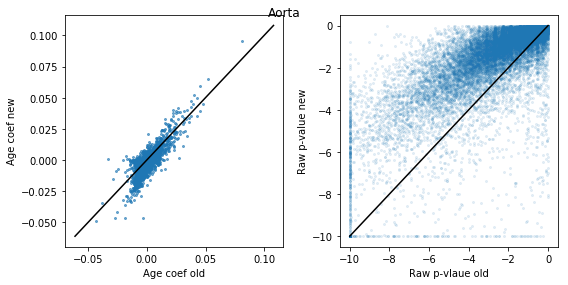

1/23, BAT, n_gene=22046, n_gene_old=19842, n_gene_overlap=19627
dif_n_young=0	dif_n_old=0
nan_prop_age=0.1075	nan_prop_raw_p=0.0000
max.r_age_coef=4.8e-01	max.r_raw_p=2.5e-01
q99.dif_age_coef=2.4e-03	q99.dif_raw_p=4.9e-02
q90.dif_age_coef=2.5e-04	q90.dif_raw_p=1.4e-02



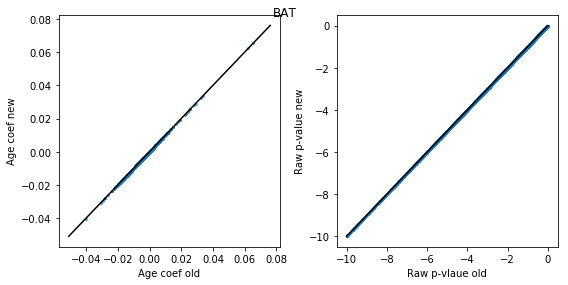

2/23, Bladder, n_gene=19540, n_gene_old=19842, n_gene_overlap=18573
dif_n_young=-77	dif_n_old=-664
nan_prop_age=0.1011	nan_prop_raw_p=0.0000
max.r_age_coef=5.1e+03	max.r_raw_p=8.1e+07
q99.dif_age_coef=2.5e+01	q99.dif_raw_p=3.6e+05
q90.dif_age_coef=2.6e+00	q90.dif_raw_p=3.4e+02



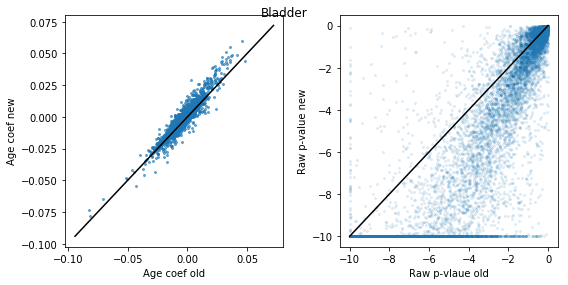

3/23, Brain_Myeloid, n_gene=22248, n_gene_old=19842, n_gene_overlap=19657
dif_n_young=0	dif_n_old=-159
nan_prop_age=0.0472	nan_prop_raw_p=0.0000
max.r_age_coef=8.7e+02	max.r_raw_p=3.7e+07
q99.dif_age_coef=9.0e+00	q99.dif_raw_p=2.8e+02
q90.dif_age_coef=9.9e-01	q90.dif_raw_p=9.6e-01



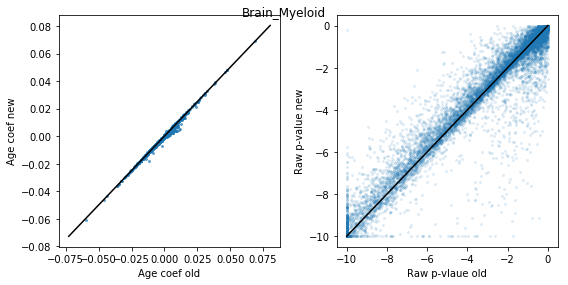

4/23, Brain_Non-Myeloid, n_gene=22474, n_gene_old=19842, n_gene_overlap=19765
dif_n_young=-208	dif_n_old=-1072
nan_prop_age=0.0364	nan_prop_raw_p=0.0000
max.r_age_coef=4.2e+03	max.r_raw_p=9.8e+07
q99.dif_age_coef=3.1e+01	q99.dif_raw_p=2.3e+05
q90.dif_age_coef=3.0e+00	q90.dif_raw_p=7.6e+01



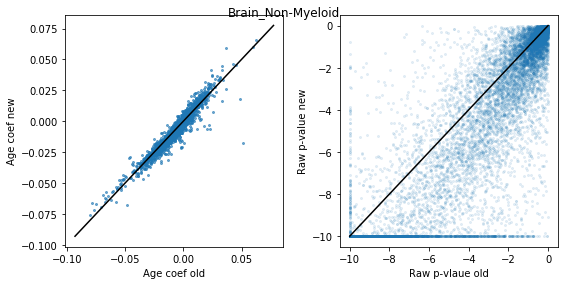

5/23, Diaphragm, n_gene=20996, n_gene_old=19842, n_gene_overlap=19100
dif_n_young=0	dif_n_old=0
nan_prop_age=0.1254	nan_prop_raw_p=0.0000
max.r_age_coef=6.6e-01	max.r_raw_p=3.1e-01
q99.dif_age_coef=1.9e-03	q99.dif_raw_p=4.9e-02
q90.dif_age_coef=1.8e-04	q90.dif_raw_p=1.1e-02



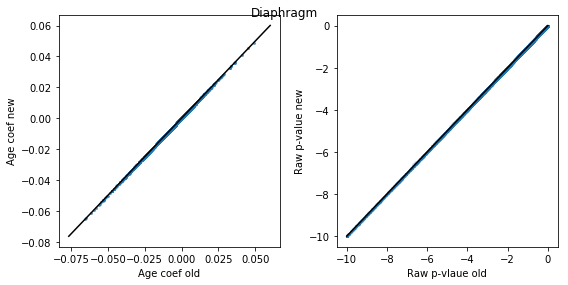

6/23, GAT, n_gene=20578, n_gene_old=19842, n_gene_overlap=19162
dif_n_young=0	dif_n_old=0
nan_prop_age=0.0846	nan_prop_raw_p=0.0000
max.r_age_coef=1.1e+00	max.r_raw_p=6.0e-01
q99.dif_age_coef=2.0e-03	q99.dif_raw_p=1.0e-01
q90.dif_age_coef=2.2e-04	q90.dif_raw_p=1.1e-02



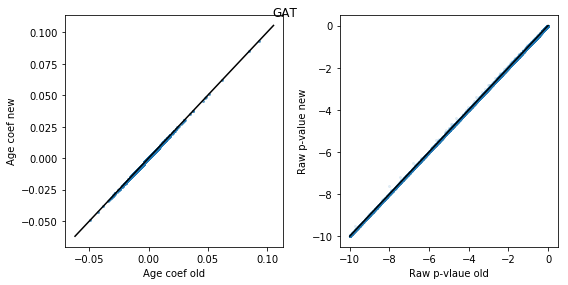

7/23, Heart, n_gene=22361, n_gene_old=19842, n_gene_overlap=19744
dif_n_young=-31	dif_n_old=-169
nan_prop_age=0.0353	nan_prop_raw_p=0.0000
max.r_age_coef=5.7e+03	max.r_raw_p=2.0e+04
q99.dif_age_coef=3.3e+00	q99.dif_raw_p=1.7e+01
q90.dif_age_coef=4.2e-01	q90.dif_raw_p=2.3e+00



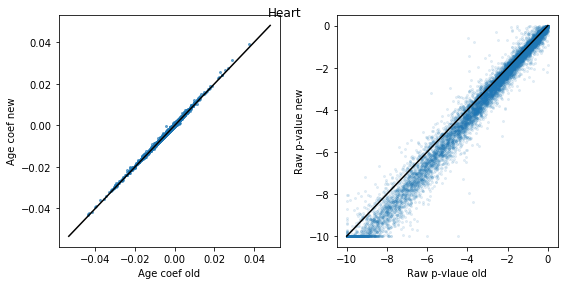

8/23, Kidney, n_gene=18344, n_gene_old=19842, n_gene_overlap=17812
dif_n_young=-59	dif_n_old=-289
nan_prop_age=0.1100	nan_prop_raw_p=0.0000
max.r_age_coef=1.2e+04	max.r_raw_p=1.2e+05
q99.dif_age_coef=1.2e+01	q99.dif_raw_p=3.5e+01
q90.dif_age_coef=1.3e+00	q90.dif_raw_p=2.3e+00



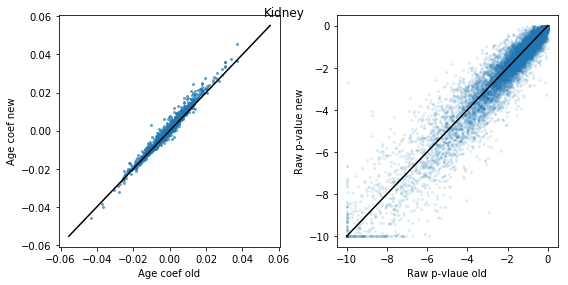

9/23, Large_Intestine, n_gene=22773, n_gene_old=19842, n_gene_overlap=19815
dif_n_young=0	dif_n_old=0
nan_prop_age=0.0222	nan_prop_raw_p=0.0000
max.r_age_coef=4.0e-01	max.r_raw_p=7.4e-01
q99.dif_age_coef=1.3e-03	q99.dif_raw_p=1.6e-01
q90.dif_age_coef=1.2e-04	q90.dif_raw_p=1.8e-02



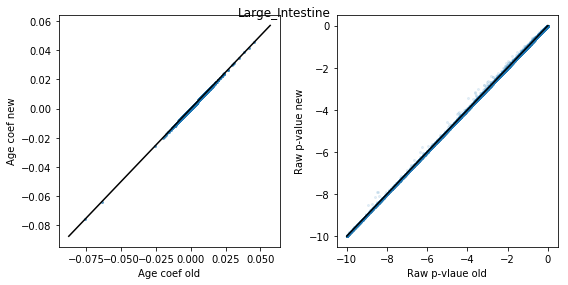

10/23, Limb_Muscle, n_gene=20695, n_gene_old=19842, n_gene_overlap=19111
dif_n_young=0	dif_n_old=0
nan_prop_age=0.0996	nan_prop_raw_p=0.0000
max.r_age_coef=1.6e+00	max.r_raw_p=4.6e-01
q99.dif_age_coef=2.9e-03	q99.dif_raw_p=9.7e-02
q90.dif_age_coef=2.8e-04	q90.dif_raw_p=1.3e-02



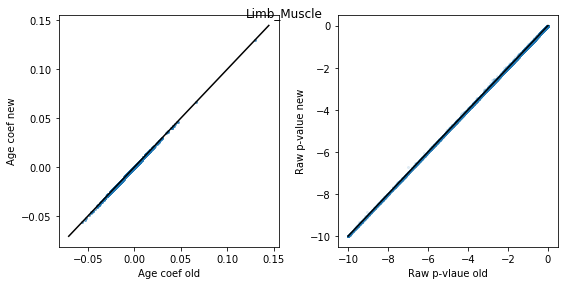

11/23, Liver, n_gene=19565, n_gene_old=19842, n_gene_overlap=18463
dif_n_young=0	dif_n_old=0
nan_prop_age=0.1069	nan_prop_raw_p=0.0000
max.r_age_coef=3.5e-01	max.r_raw_p=7.9e-01
q99.dif_age_coef=1.9e-03	q99.dif_raw_p=9.0e-02
q90.dif_age_coef=2.0e-04	q90.dif_raw_p=5.6e-03



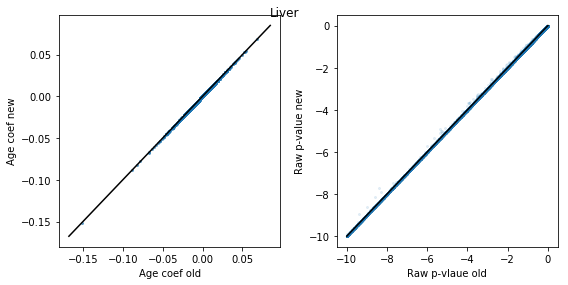

12/23, Lung, n_gene=21442, n_gene_old=19842, n_gene_overlap=19455
dif_n_young=-362	dif_n_old=-495
nan_prop_age=0.0716	nan_prop_raw_p=0.0000
max.r_age_coef=1.8e+03	max.r_raw_p=1.4e+06
q99.dif_age_coef=1.8e+01	q99.dif_raw_p=3.5e+02
q90.dif_age_coef=1.7e+00	q90.dif_raw_p=8.2e+00



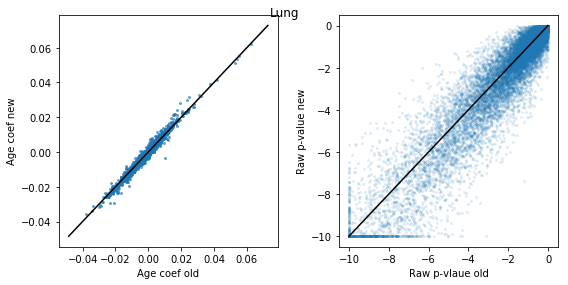

13/23, MAT, n_gene=20175, n_gene_old=19842, n_gene_overlap=18944
dif_n_young=0	dif_n_old=0
nan_prop_age=0.0901	nan_prop_raw_p=0.0000
max.r_age_coef=1.2e-01	max.r_raw_p=4.0e-01
q99.dif_age_coef=2.6e-03	q99.dif_raw_p=6.7e-02
q90.dif_age_coef=2.8e-04	q90.dif_raw_p=8.2e-03



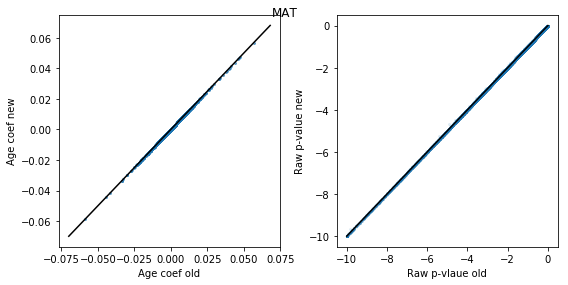

14/23, Mammary_Gland, n_gene=19624, n_gene_old=19842, n_gene_overlap=18652
dif_n_young=-502	dif_n_old=0
nan_prop_age=0.1248	nan_prop_raw_p=0.0000
max.r_age_coef=4.8e+03	max.r_raw_p=1.9e+05
q99.dif_age_coef=1.5e+01	q99.dif_raw_p=2.6e+01
q90.dif_age_coef=1.4e+00	q90.dif_raw_p=1.0e+00



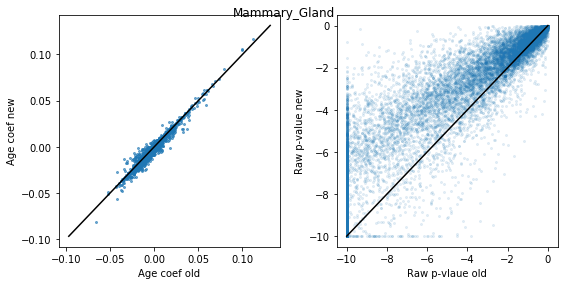

15/23, Marrow, n_gene=22438, n_gene_old=19842, n_gene_overlap=19736
dif_n_young=0	dif_n_old=-1
nan_prop_age=0.0288	nan_prop_raw_p=0.0000
max.r_age_coef=1.4e+01	max.r_raw_p=4.0e+00
q99.dif_age_coef=3.7e-02	q99.dif_raw_p=9.1e-02
q90.dif_age_coef=1.8e-03	q90.dif_raw_p=1.2e-02



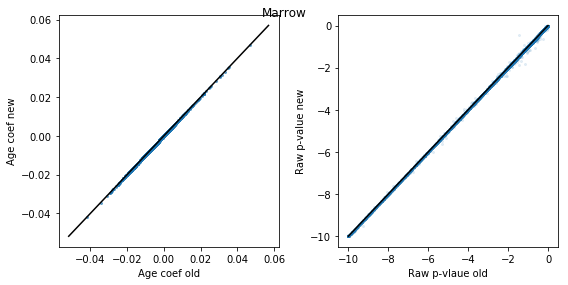

16/23, Pancreas, n_gene=21289, n_gene_old=19842, n_gene_overlap=19327
dif_n_young=0	dif_n_old=0
nan_prop_age=0.0653	nan_prop_raw_p=0.0000
max.r_age_coef=9.3e-01	max.r_raw_p=5.2e-01
q99.dif_age_coef=1.9e-03	q99.dif_raw_p=8.9e-02
q90.dif_age_coef=1.9e-04	q90.dif_raw_p=9.0e-03



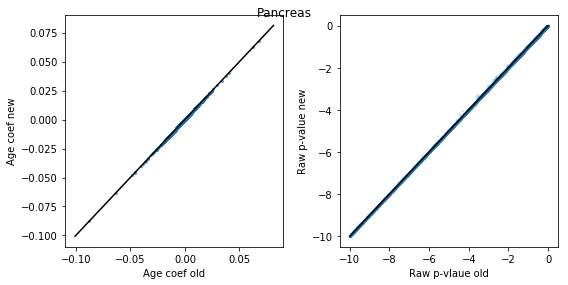

17/23, SCAT, n_gene=21652, n_gene_old=19842, n_gene_overlap=19548
dif_n_young=0	dif_n_old=0
nan_prop_age=0.0692	nan_prop_raw_p=0.0000
max.r_age_coef=5.3e-01	max.r_raw_p=5.2e-01
q99.dif_age_coef=2.2e-03	q99.dif_raw_p=7.5e-02
q90.dif_age_coef=2.4e-04	q90.dif_raw_p=1.1e-02



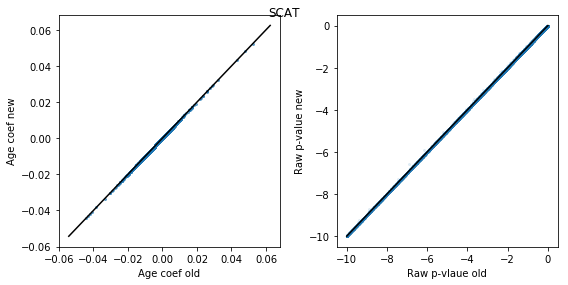

18/23, Skin, n_gene=21219, n_gene_old=19842, n_gene_overlap=19320
dif_n_young=0	dif_n_old=0
nan_prop_age=0.0939	nan_prop_raw_p=0.0000
max.r_age_coef=2.9e+00	max.r_raw_p=6.9e-01
q99.dif_age_coef=2.3e-03	q99.dif_raw_p=1.2e-01
q90.dif_age_coef=2.2e-04	q90.dif_raw_p=6.2e-03



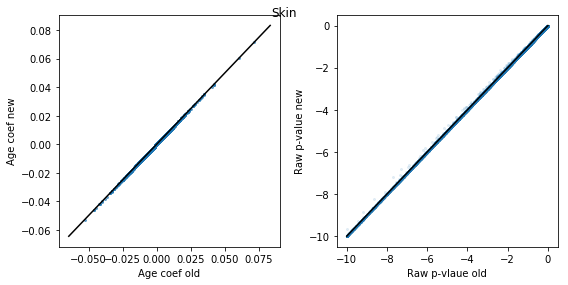

19/23, Spleen, n_gene=19838, n_gene_old=19842, n_gene_overlap=18629
dif_n_young=0	dif_n_old=0
nan_prop_age=0.1246	nan_prop_raw_p=0.0000
max.r_age_coef=1.5e+00	max.r_raw_p=2.3e-01
q99.dif_age_coef=2.3e-03	q99.dif_raw_p=3.5e-02
q90.dif_age_coef=2.2e-04	q90.dif_raw_p=7.2e-04



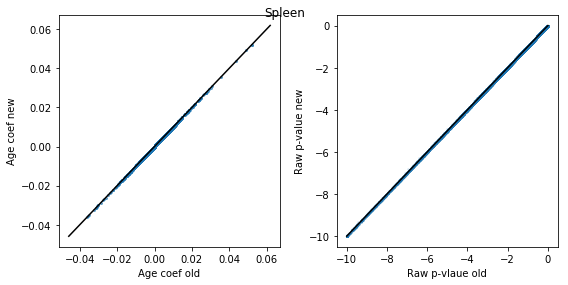

20/23, Thymus, n_gene=22150, n_gene_old=19842, n_gene_overlap=19617
dif_n_young=0	dif_n_old=-28
nan_prop_age=0.0621	nan_prop_raw_p=0.0000
max.r_age_coef=4.8e+02	max.r_raw_p=2.2e+02
q99.dif_age_coef=1.3e+00	q99.dif_raw_p=1.9e+00
q90.dif_age_coef=1.5e-01	q90.dif_raw_p=3.8e-01



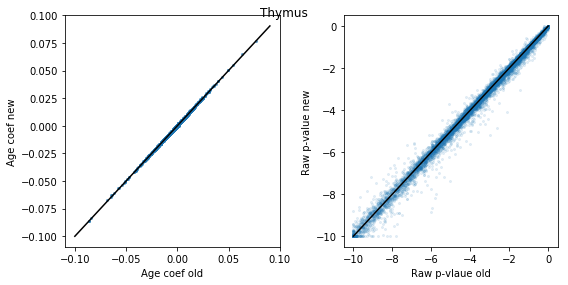

21/23, Tongue, n_gene=20189, n_gene_old=19842, n_gene_overlap=18993
dif_n_young=0	dif_n_old=0
nan_prop_age=0.0813	nan_prop_raw_p=0.0000
max.r_age_coef=1.8e-01	max.r_raw_p=4.3e-01
q99.dif_age_coef=1.4e-03	q99.dif_raw_p=5.4e-02
q90.dif_age_coef=1.3e-04	q90.dif_raw_p=3.2e-03



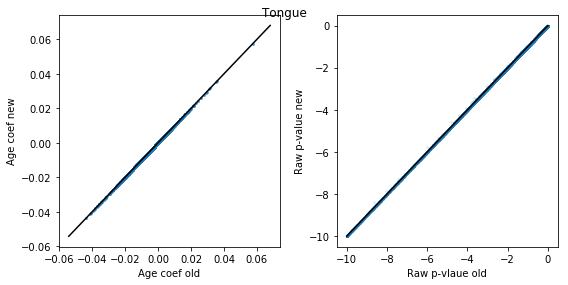

22/23, Trachea, n_gene=21294, n_gene_old=19842, n_gene_overlap=19483
dif_n_young=0	dif_n_old=0
nan_prop_age=0.0617	nan_prop_raw_p=0.0000
max.r_age_coef=4.0e-01	max.r_raw_p=4.7e-01
q99.dif_age_coef=1.6e-03	q99.dif_raw_p=1.1e-01
q90.dif_age_coef=1.5e-04	q90.dif_raw_p=1.4e-02



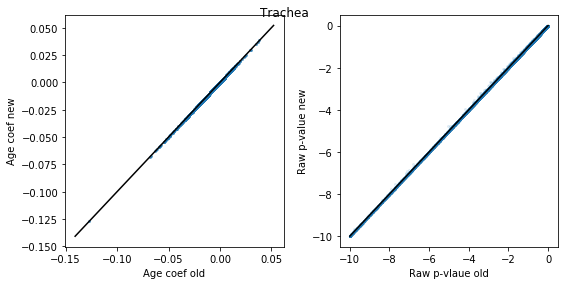

droplet
new reuslt only: set()
old reuslt only: set()

0/11, Bladder, n_gene=17909, n_gene_old=19842, n_gene_overlap=17861
dif_n_young=18	dif_n_old=110
nan_prop_age=0.0755	nan_prop_raw_p=0.0010
max.r_age_coef=1.6e+02	max.r_raw_p=1.5e+03
q99.dif_age_coef=2.6e+00	q99.dif_raw_p=2.1e+01
q90.dif_age_coef=2.6e-01	q90.dif_raw_p=9.7e-01



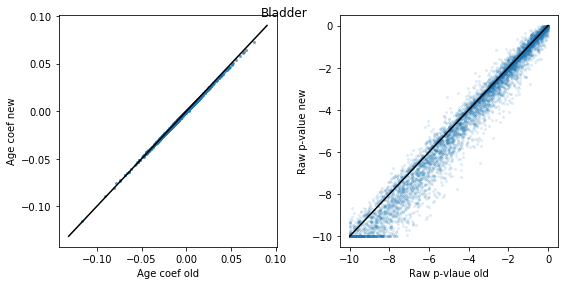

1/11, Heart_and_Aorta, n_gene=17599, n_gene_old=19842, n_gene_overlap=17562
dif_n_young=118	dif_n_old=579
nan_prop_age=0.0837	nan_prop_raw_p=0.0026
max.r_age_coef=2.1e+03	max.r_raw_p=1.3e+04
q99.dif_age_coef=1.3e+01	q99.dif_raw_p=1.8e+01
q90.dif_age_coef=1.3e+00	q90.dif_raw_p=1.7e+00



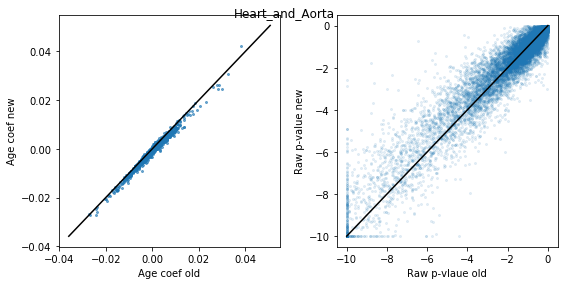

2/11, Kidney, n_gene=18734, n_gene_old=19842, n_gene_overlap=18663
dif_n_young=501	dif_n_old=2045
nan_prop_age=0.0596	nan_prop_raw_p=0.0019
max.r_age_coef=2.8e+03	max.r_raw_p=2.0e+04
q99.dif_age_coef=6.8e+00	q99.dif_raw_p=2.1e+01
q90.dif_age_coef=6.5e-01	q90.dif_raw_p=1.2e+00



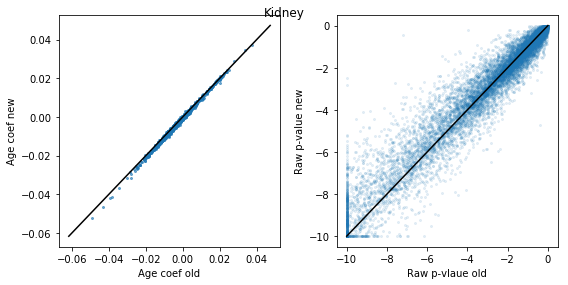

3/11, Limb_Muscle, n_gene=18629, n_gene_old=19842, n_gene_overlap=18552
dif_n_young=1097	dif_n_old=2801
nan_prop_age=0.0672	nan_prop_raw_p=0.0031
max.r_age_coef=3.4e+03	max.r_raw_p=4.6e+05
q99.dif_age_coef=1.2e+01	q99.dif_raw_p=1.6e+01
q90.dif_age_coef=1.2e+00	q90.dif_raw_p=9.9e-01



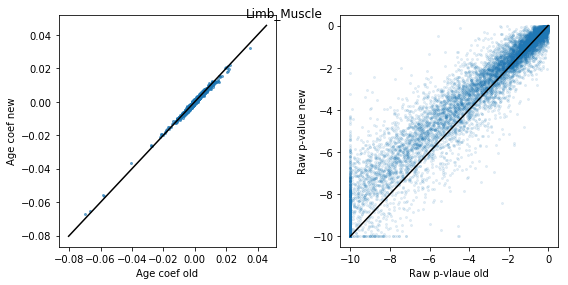

4/11, Liver, n_gene=17279, n_gene_old=19842, n_gene_overlap=17247
dif_n_young=583	dif_n_old=231
nan_prop_age=0.0985	nan_prop_raw_p=0.0026
max.r_age_coef=5.3e+02	max.r_raw_p=3.3e+04
q99.dif_age_coef=8.2e+00	q99.dif_raw_p=5.3e+00
q90.dif_age_coef=7.4e-01	q90.dif_raw_p=6.8e-01



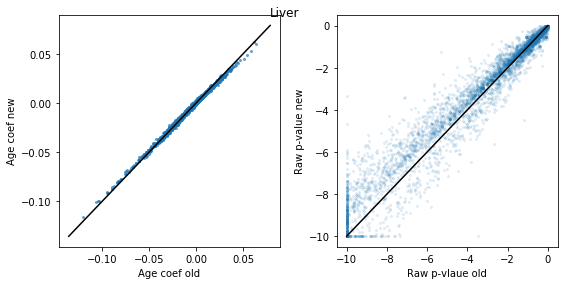

5/11, Lung, n_gene=18143, n_gene_old=19842, n_gene_overlap=18096
dif_n_young=-421	dif_n_old=-2796
nan_prop_age=0.0775	nan_prop_raw_p=0.0027
max.r_age_coef=1.9e+03	max.r_raw_p=6.5e+07
q99.dif_age_coef=1.4e+01	q99.dif_raw_p=2.4e+05
q90.dif_age_coef=1.2e+00	q90.dif_raw_p=1.3e+02



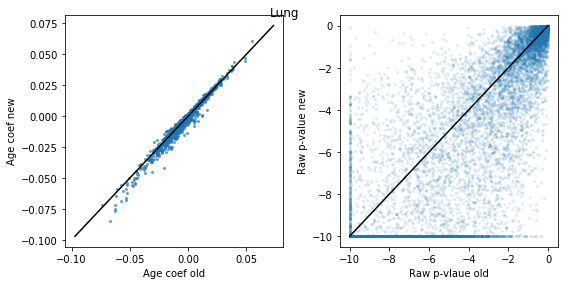

6/11, Mammary_Gland, n_gene=18303, n_gene_old=19842, n_gene_overlap=18250
dif_n_young=138	dif_n_old=765
nan_prop_age=0.0719	nan_prop_raw_p=0.0009
max.r_age_coef=1.1e+03	max.r_raw_p=1.6e+05
q99.dif_age_coef=5.9e+00	q99.dif_raw_p=2.7e+02
q90.dif_age_coef=5.6e-01	q90.dif_raw_p=6.6e+00



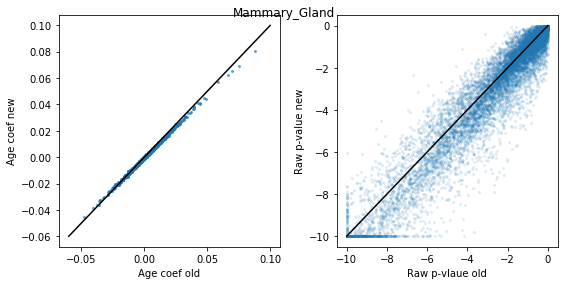

7/11, Marrow, n_gene=17617, n_gene_old=19842, n_gene_overlap=17560
dif_n_young=-325	dif_n_old=-1396
nan_prop_age=0.0862	nan_prop_raw_p=0.0000
max.r_age_coef=5.6e+02	max.r_raw_p=1.0e+06
q99.dif_age_coef=5.3e+00	q99.dif_raw_p=1.7e+01
q90.dif_age_coef=4.3e-01	q90.dif_raw_p=8.3e-01



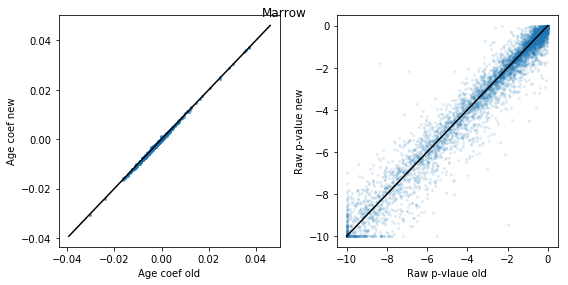

8/11, Spleen, n_gene=17580, n_gene_old=19842, n_gene_overlap=17540
dif_n_young=2279	dif_n_old=4117
nan_prop_age=0.0928	nan_prop_raw_p=0.0047
max.r_age_coef=1.0e+03	max.r_raw_p=6.1e+05
q99.dif_age_coef=1.2e+01	q99.dif_raw_p=4.7e+00
q90.dif_age_coef=1.1e+00	q90.dif_raw_p=9.0e-01



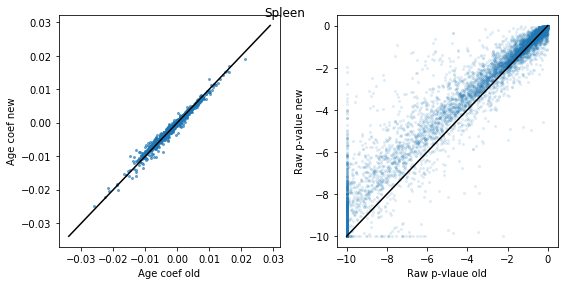

9/11, Thymus, n_gene=16227, n_gene_old=19842, n_gene_overlap=16206
dif_n_young=285	dif_n_old=1420
nan_prop_age=0.1299	nan_prop_raw_p=0.0069
max.r_age_coef=1.1e+03	max.r_raw_p=4.0e+03
q99.dif_age_coef=1.6e+01	q99.dif_raw_p=3.5e+01
q90.dif_age_coef=1.8e+00	q90.dif_raw_p=2.3e+00



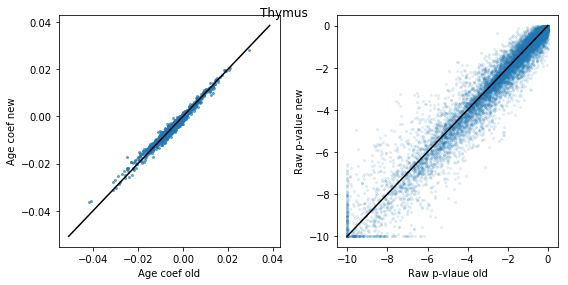

10/11, Tongue, n_gene=17960, n_gene_old=19842, n_gene_overlap=17892
dif_n_young=1	dif_n_old=22
nan_prop_age=0.0799	nan_prop_raw_p=0.0002
max.r_age_coef=6.8e+02	max.r_raw_p=3.8e+01
q99.dif_age_coef=1.4e+00	q99.dif_raw_p=1.4e+00
q90.dif_age_coef=1.1e-01	q90.dif_raw_p=3.9e-01



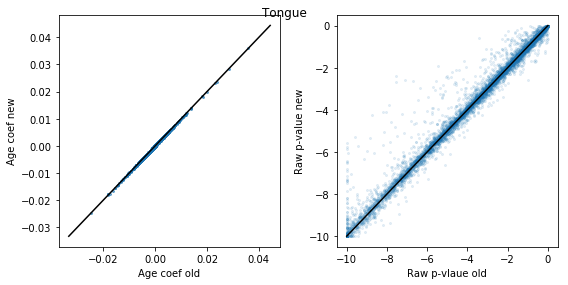

In [7]:
# Compare results on old data and new data
dname_list = ['facs','droplet']
# dname_list = ['droplet']
for dname in dname_list:
    print(dname)
    if dname=='facs':
        dname_ = 'FACS'
    else:
        dname_ = dname
    with open(DGE_RES_PATH_OLD+'/DE_tissue_%s.pickle'%dname_, 'rb') as handle:
        dic_res_old = pickle.load(handle)
        analysis_list_old = pickle.load(handle)
        analysis_info_old = pickle.load(handle)
    
    df_info,dic_res = util.load_DGE_res(DATA_PATH, dname='%s.tissue'%dname)
    
    # compare
    analysis_list = list(df_info.index)
    print('new reuslt only:', set(analysis_list) - set(analysis_list_old))
    print('old reuslt only:', set(analysis_list_old) - set(analysis_list))
    print('')
    temp_list = list(set(analysis_list) & set(analysis_list_old))
    temp_list.sort()
    
    for i_tissue,tissue in enumerate(temp_list):
        if tissue not in dic_res.keys():
            continue

        n_dif_young = df_info.loc[tissue, 'n_cell_young'] - analysis_info_old[tissue]['n_young']
        n_dif_old = df_info.loc[tissue, 'n_cell_old'] - analysis_info_old[tissue]['n_old']
        
        # comparing the DGE results 
        gene_list = dic_res[tissue].index
        gene_list_old = dic_res_old[tissue].index
        gene_list_common = list(set(gene_list) & set(gene_list_old))
        temp_df = dic_res[tissue].loc[gene_list_common]
        temp_df_old = dic_res_old[tissue].loc[gene_list_common]\
        
        v_coef = np.array(temp_df['age.logFC']) 
        v_nan_coef = np.isnan(v_coef)
        v_coef_old = np.array(temp_df_old['coef']) 
        v_nan_coef_old = np.isnan(v_coef_old)
        ind_select = (~v_nan_coef) & (~v_nan_coef_old)
        v_coef = v_coef[ind_select]
        v_coef_old = v_coef_old[ind_select]
        r_coef = np.absolute(v_coef - v_coef_old)/ (np.absolute(v_coef_old).clip(min=1e-8))
        
        v_raw_p = np.array(temp_df['age.H_p']) 
        v_nan_raw_p = np.isnan(v_raw_p)
        v_raw_p_old = np.array(temp_df_old['raw-p']) 
        v_nan_raw_p_old = np.isnan(v_raw_p_old)
        ind_select = (~v_nan_raw_p) & (~v_nan_raw_p_old)
        v_raw_p = v_raw_p[ind_select]
        v_raw_p_old = v_raw_p_old[ind_select]
        r_raw_p = np.absolute(v_raw_p - v_raw_p_old)/ (np.absolute(v_raw_p_old).clip(min=1e-8))
        
        print('%d/%d, %s, n_gene=%d, n_gene_old=%d, n_gene_overlap=%d'
                  %(i_tissue, len(temp_list), tissue,
                    len(gene_list), len(gene_list_old), len(gene_list_common)))
        print('dif_n_young=%d\tdif_n_old=%d'%(n_dif_young,n_dif_old))
        print('nan_prop_age=%0.4f\tnan_prop_raw_p=%0.4f'
              %((v_nan_coef|v_nan_coef_old).sum()/v_nan_coef.shape[0],
               (v_nan_raw_p|v_nan_raw_p_old).sum()/v_nan_raw_p.shape[0],))
        print('max.r_age_coef=%0.1e\tmax.r_raw_p=%0.1e'
              %(r_coef.max(), r_raw_p.max()))
        print('q99.dif_age_coef=%0.1e\tq99.dif_raw_p=%0.1e'
              %(np.quantile(r_coef, 0.99), np.quantile(r_raw_p, 0.99)))
        print('q90.dif_age_coef=%0.1e\tq90.dif_raw_p=%0.1e'
              %(np.quantile(r_coef, 0.90), np.quantile(r_raw_p, 0.90)))
        print('')      
            
        plt.figure(figsize=[8,4])
        
        plt.subplot(121)
        plt.scatter(v_coef_old, v_coef, s=4, alpha=0.6)
        x_min,x_max = plt.xlim()
        y_min,y_max = plt.ylim()
        min_,max_ = min(x_min,y_min), max(x_max,y_max)
        plt.plot([min_, max_], [min_, max_], color='k')
        plt.xlabel('Age coef old')
        plt.ylabel('Age coef new')
        
        
        plt.subplot(122)
        plt.scatter(np.log10(v_raw_p.clip(min=1e-10)), np.log10(v_raw_p_old.clip(min=1e-10)), s=4, alpha=0.1)
        plt.plot([-10, 0], [-10, 0], color='k')
        plt.xlabel('Raw p-vlaue old')
        plt.ylabel('Raw p-value new')
        plt.suptitle(tissue)
        plt.tight_layout()
        plt.show()


### FACS and droplet data: tissue_cell

In [8]:
# check missing for the new data 
dname_list = ['facs', 'facs_old', 'droplet', 'droplet_old']
# dname_list = ['droplet']
for dname in dname_list:
    print(dname)    
    df_info,dic_res = util.load_DGE_res(DATA_PATH, dname='%s.tc'%dname)
    print('')

facs

facs_old

droplet

droplet_old



In [9]:
dname_list = ['facs','droplet']
# dname_list = ['facs']
for dname in dname_list:
    print(dname)
    if dname=='facs':
        dname_ = 'FACS'
    else:
        dname_ = dname
    with open(DGE_RES_PATH_OLD+'/DE_tissue_cell_%s.pickle'%dname_, 'rb') as handle:
        dic_res_old = pickle.load(handle)
        analysis_list_old = pickle.load(handle)
        analysis_info_old = pickle.load(handle)
    
    df_info,dic_res = util.load_DGE_res(DATA_PATH, dname='%s_old.tc'%dname)
    
    # compare
    analysis_list = list(df_info.index)
    print('new reuslt only:', set(analysis_list) - set(analysis_list_old))
    print('old reuslt only:', set(analysis_list_old) - set(analysis_list))
    print('')
    temp_list = list(set(analysis_list) & set(analysis_list_old))
    temp_list.sort()
    for i_tissue,tissue in enumerate(temp_list):
        if tissue not in dic_res.keys():
            continue

        n_dif_young = df_info.loc[tissue, 'n_cell_young'] - analysis_info_old[tissue]['n_young']
        n_dif_old = df_info.loc[tissue, 'n_cell_old'] - analysis_info_old[tissue]['n_old']
        
        # comparing the DGE results 
        gene_list = dic_res[tissue].index
        gene_list_old = dic_res_old[tissue].index
        gene_list_common = list(set(gene_list) & set(gene_list_old))
        temp_df = dic_res[tissue].loc[gene_list_common]
        temp_df_old = dic_res_old[tissue].loc[gene_list_common]
        
        v_coef = np.array(temp_df['age.coef']) 
        v_nan_coef = np.isnan(v_coef)
        v_coef_old = np.array(temp_df_old['coef']) 
        v_nan_coef_old = np.isnan(v_coef_old)
        ind_select = (~v_nan_coef) & (~v_nan_coef_old)
        v_coef = v_coef[ind_select]
        v_coef_old = v_coef_old[ind_select]
        r_coef = np.absolute(v_coef - v_coef_old)/ (np.absolute(v_coef_old).clip(min=1e-8))
        
        v_raw_p = np.array(temp_df['age.raw_p']) 
        v_nan_raw_p = np.isnan(v_raw_p)
        v_raw_p_old = np.array(temp_df_old['raw-p']) 
        v_nan_raw_p_old = np.isnan(v_raw_p_old)
        ind_select = (~v_nan_raw_p) & (~v_nan_raw_p_old)
        v_raw_p = v_raw_p[ind_select]
        v_raw_p_old = v_raw_p_old[ind_select]
        r_raw_p = np.absolute(v_raw_p - v_raw_p_old)/ (np.absolute(v_raw_p_old).clip(min=1e-8))
    
        
        # tell if the results are the same 
        flag_dif = (n_dif_young==0) & (n_dif_old==0) & \
                    (np.quantile(r_coef, 0.99)<1e-2) & (np.quantile(r_raw_p, 0.99)<1e-1)
        
        if flag_dif==False:
            print('%d/%d, %s, n_gene=%d, n_gene_old=%d, n_gene_overlap=%d'
                  %(i_tissue, len(temp_list), tissue,
                    len(gene_list), len(gene_list_old), len(gene_list_common)))
            print('dif_n_young=%d\tdif_n_old=%d'%(n_dif_young,n_dif_old))
            print('nan_prop_age=%0.4f\tnan_prop_raw_p=%0.4f'
                  %((v_nan_coef|v_nan_coef_old).sum()/v_nan_coef.shape[0],
                   (v_nan_raw_p|v_nan_raw_p_old).sum()/v_nan_raw_p.shape[0],))
            print('max.r_age_coef=%0.1e\tmax.r_raw_p=%0.1e'
                  %(r_coef.max(), r_raw_p.max()))
            print('q99.dif_age_coef=%0.1e\tq99.dif_raw_p=%0.1e'
                  %(np.quantile(r_coef, 0.99), np.quantile(r_raw_p, 0.99)))
            print('q90.dif_age_coef=%0.1e\tq90.dif_raw_p=%0.1e'
                  %(np.quantile(r_coef, 0.90), np.quantile(r_raw_p, 0.90)))
            print('')  

facs
new reuslt only: set()
old reuslt only: set()

61/131, Liver.hepatocyte, n_gene=17018, n_gene_old=19842, n_gene_overlap=16642
dif_n_young=0	dif_n_old=0
nan_prop_age=0.1338	nan_prop_raw_p=0.0000
max.r_age_coef=2.3e-04	max.r_raw_p=5.7e-01
q99.dif_age_coef=5.2e-07	q99.dif_raw_p=1.0e-01
q90.dif_age_coef=5.9e-08	q90.dif_raw_p=2.7e-03

128/131, Trachea.fibroblast, n_gene=19097, n_gene_old=19842, n_gene_overlap=18249
dif_n_young=0	dif_n_old=0
nan_prop_age=0.1268	nan_prop_raw_p=0.0000
max.r_age_coef=2.0e-04	max.r_raw_p=4.9e-01
q99.dif_age_coef=8.3e-07	q99.dif_raw_p=1.1e-01
q90.dif_age_coef=8.6e-08	q90.dif_raw_p=1.2e-02

droplet
new reuslt only: set()
old reuslt only: set()



facs
new reuslt only: set()
old reuslt only: set()

10/131, Brain_Myeloid.macrophage, n_gene=15080, n_gene_old=19842, n_gene_overlap=14761
dif_n_young=0	dif_n_old=0
nan_prop_age=0.2219	nan_prop_raw_p=0.0000
max.r_age_coef=1.2e-01	max.r_raw_p=8.1e-02
q99.dif_age_coef=1.9e-03	q99.dif_raw_p=2.3e-02
q90.dif_age_coef=2.0e-04	q90.dif_raw_p=6.5e-03



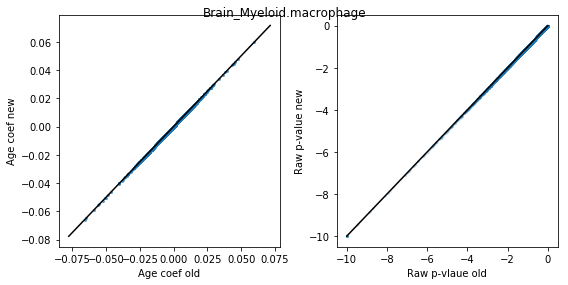

12/131, Brain_Non-Myeloid.astrocyte, n_gene=17334, n_gene_old=19842, n_gene_overlap=16844
dif_n_young=0	dif_n_old=0
nan_prop_age=0.2266	nan_prop_raw_p=0.0000
max.r_age_coef=4.4e-01	max.r_raw_p=4.3e-01
q99.dif_age_coef=5.9e-03	q99.dif_raw_p=7.2e-02
q90.dif_age_coef=6.9e-04	q90.dif_raw_p=9.3e-03



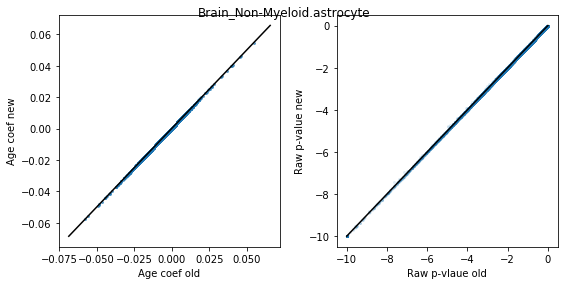

15/131, Brain_Non-Myeloid.interneuron, n_gene=14389, n_gene_old=19842, n_gene_overlap=14207
dif_n_young=0	dif_n_old=0
nan_prop_age=0.2797	nan_prop_raw_p=0.0000
max.r_age_coef=1.3e+00	max.r_raw_p=6.7e-02
q99.dif_age_coef=6.0e-03	q99.dif_raw_p=1.9e-02
q90.dif_age_coef=5.1e-04	q90.dif_raw_p=5.6e-03



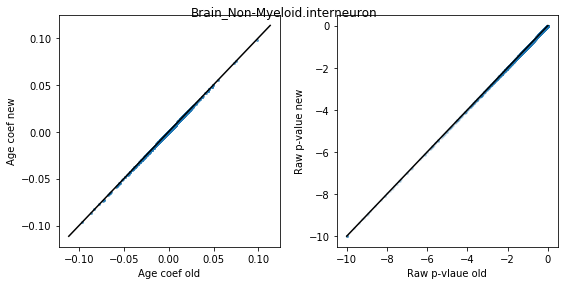

16/131, Brain_Non-Myeloid.neuron, n_gene=18234, n_gene_old=19842, n_gene_overlap=17560
dif_n_young=0	dif_n_old=0
nan_prop_age=0.1413	nan_prop_raw_p=0.0000
max.r_age_coef=2.1e-01	max.r_raw_p=2.4e-01
q99.dif_age_coef=6.8e-03	q99.dif_raw_p=7.5e-02
q90.dif_age_coef=6.3e-04	q90.dif_raw_p=1.7e-02



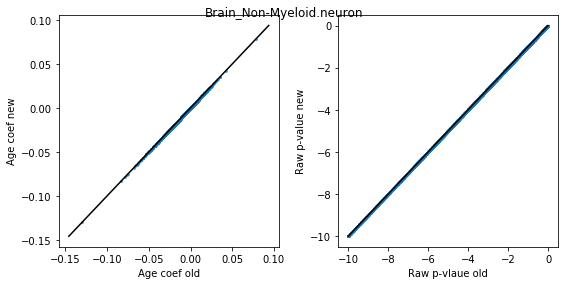

17/131, Brain_Non-Myeloid.oligodendrocyte, n_gene=19616, n_gene_old=19842, n_gene_overlap=18468
dif_n_young=0	dif_n_old=0
nan_prop_age=0.1514	nan_prop_raw_p=0.0000
max.r_age_coef=1.6e+00	max.r_raw_p=5.1e-01
q99.dif_age_coef=2.7e-03	q99.dif_raw_p=8.2e-02
q90.dif_age_coef=2.8e-04	q90.dif_raw_p=1.1e-03



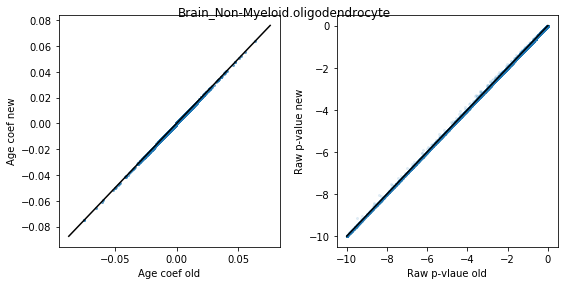

21/131, Diaphragm.macrophage, n_gene=12425, n_gene_old=19842, n_gene_overlap=12350
dif_n_young=0	dif_n_old=0
nan_prop_age=0.3207	nan_prop_raw_p=0.0000
max.r_age_coef=2.0e-01	max.r_raw_p=2.0e-02
q99.dif_age_coef=1.0e-03	q99.dif_raw_p=4.8e-03
q90.dif_age_coef=7.4e-05	q90.dif_raw_p=1.6e-03



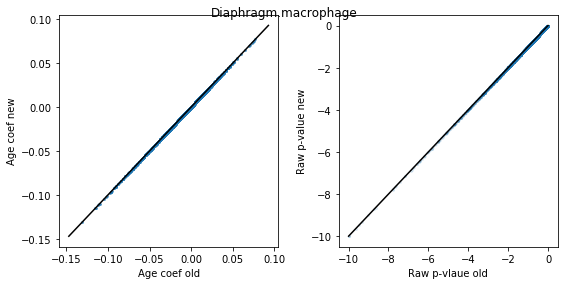

34/131, Heart.monocyte, n_gene=18986, n_gene_old=19842, n_gene_overlap=18058
dif_n_young=0	dif_n_old=0
nan_prop_age=0.1507	nan_prop_raw_p=0.0000
max.r_age_coef=1.8e+00	max.r_raw_p=3.4e-01
q99.dif_age_coef=1.6e-03	q99.dif_raw_p=6.3e-02
q90.dif_age_coef=1.6e-04	q90.dif_raw_p=6.8e-03



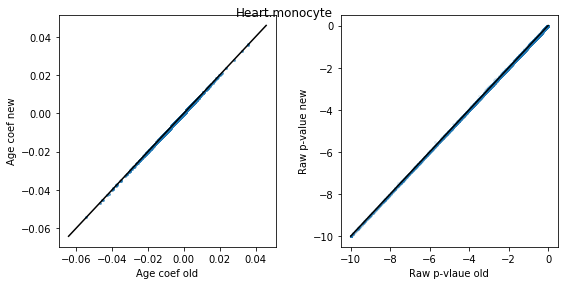

43/131, Kidney.macrophage, n_gene=14255, n_gene_old=19842, n_gene_overlap=14092
dif_n_young=0	dif_n_old=0
nan_prop_age=0.2362	nan_prop_raw_p=0.0000
max.r_age_coef=2.8e-01	max.r_raw_p=6.5e-02
q99.dif_age_coef=1.4e-03	q99.dif_raw_p=2.4e-02
q90.dif_age_coef=1.5e-04	q90.dif_raw_p=5.9e-03



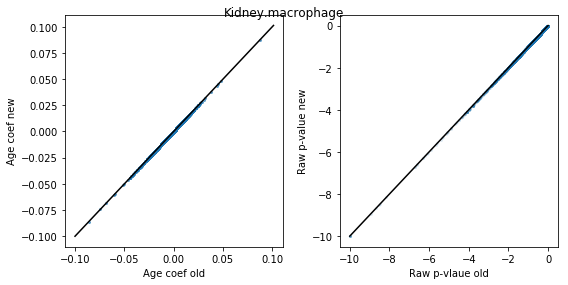

55/131, Limb_Muscle.macrophage, n_gene=15729, n_gene_old=19842, n_gene_overlap=15428
dif_n_young=0	dif_n_old=0
nan_prop_age=0.2436	nan_prop_raw_p=0.0000
max.r_age_coef=9.4e-01	max.r_raw_p=3.0e-02
q99.dif_age_coef=1.9e-03	q99.dif_raw_p=9.8e-03
q90.dif_age_coef=1.9e-04	q90.dif_raw_p=3.2e-03



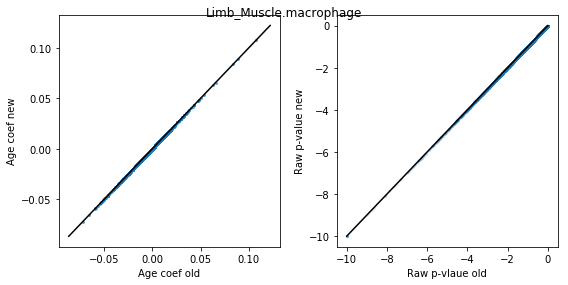

61/131, Liver.hepatocyte, n_gene=17018, n_gene_old=19842, n_gene_overlap=16640
dif_n_young=0	dif_n_old=0
nan_prop_age=0.1338	nan_prop_raw_p=0.0000
max.r_age_coef=4.1e-01	max.r_raw_p=5.7e-01
q99.dif_age_coef=1.4e-03	q99.dif_raw_p=1.0e-01
q90.dif_age_coef=1.7e-04	q90.dif_raw_p=2.7e-03



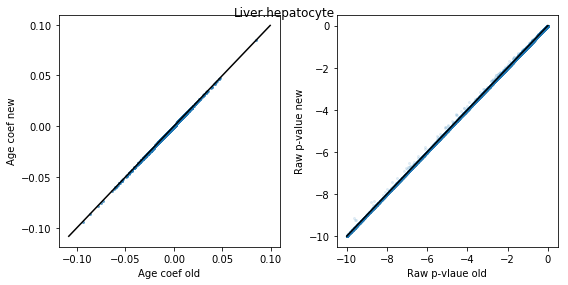

70/131, Lung.neutrophil, n_gene=11873, n_gene_old=19842, n_gene_overlap=11785
dif_n_young=0	dif_n_old=0
nan_prop_age=0.4073	nan_prop_raw_p=0.0000
max.r_age_coef=4.0e-02	max.r_raw_p=1.2e-02
q99.dif_age_coef=4.3e-04	q99.dif_raw_p=5.0e-03
q90.dif_age_coef=3.2e-05	q90.dif_raw_p=1.5e-03



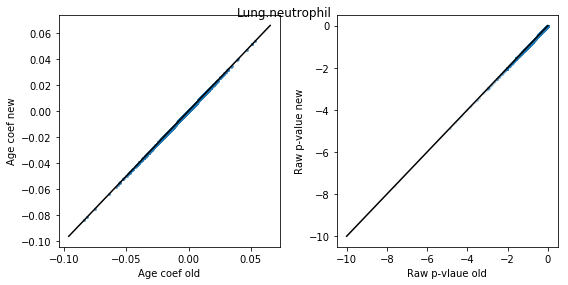

80/131, MAT.macrophage, n_gene=15041, n_gene_old=19842, n_gene_overlap=14834
dif_n_young=0	dif_n_old=0
nan_prop_age=0.2048	nan_prop_raw_p=0.0000
max.r_age_coef=4.7e-02	max.r_raw_p=1.4e-01
q99.dif_age_coef=2.1e-03	q99.dif_raw_p=2.5e-02
q90.dif_age_coef=1.9e-04	q90.dif_raw_p=5.8e-03



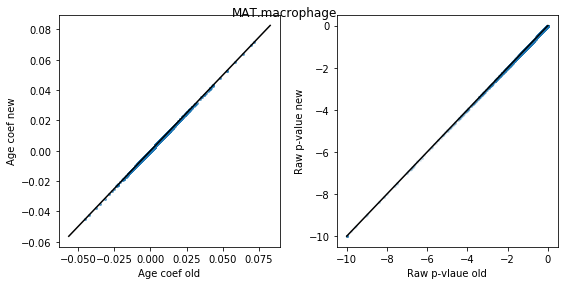

88/131, Marrow.basophil, n_gene=13630, n_gene_old=19842, n_gene_overlap=13499
dif_n_young=0	dif_n_old=0
nan_prop_age=0.2309	nan_prop_raw_p=0.0000
max.r_age_coef=3.4e-01	max.r_raw_p=3.4e-02
q99.dif_age_coef=4.3e-03	q99.dif_raw_p=1.2e-02
q90.dif_age_coef=3.7e-04	q90.dif_raw_p=3.9e-03



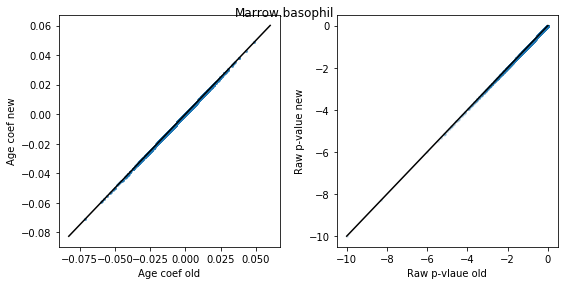

90/131, Marrow.granulocyte, n_gene=19560, n_gene_old=19842, n_gene_overlap=18321
dif_n_young=0	dif_n_old=0
nan_prop_age=0.1579	nan_prop_raw_p=0.0000
max.r_age_coef=3.5e-01	max.r_raw_p=2.2e-01
q99.dif_age_coef=1.3e-03	q99.dif_raw_p=3.7e-02
q90.dif_age_coef=1.1e-04	q90.dif_raw_p=1.7e-03



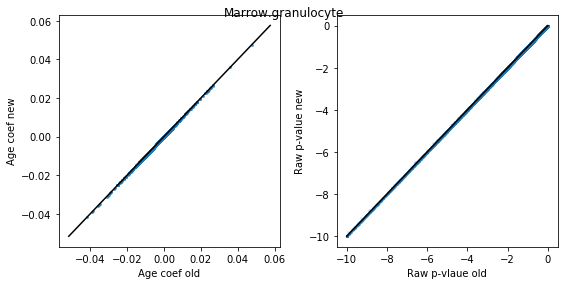

96/131, Marrow.macrophage, n_gene=16413, n_gene_old=19842, n_gene_overlap=15941
dif_n_young=0	dif_n_old=0
nan_prop_age=0.2022	nan_prop_raw_p=0.0000
max.r_age_coef=1.4e-01	max.r_raw_p=2.1e-01
q99.dif_age_coef=4.7e-03	q99.dif_raw_p=3.3e-02
q90.dif_age_coef=4.8e-04	q90.dif_raw_p=6.9e-03



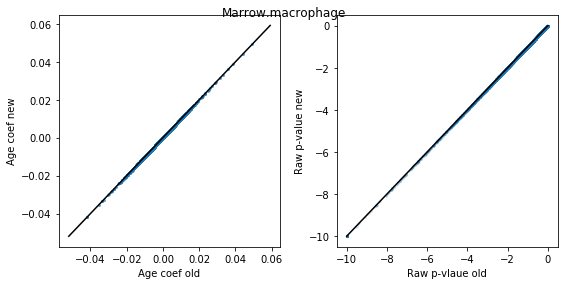

100/131, Marrow.promonocyte, n_gene=18018, n_gene_old=19842, n_gene_overlap=17381
dif_n_young=0	dif_n_old=0
nan_prop_age=0.1568	nan_prop_raw_p=0.0000
max.r_age_coef=9.5e-02	max.r_raw_p=4.0e-01
q99.dif_age_coef=2.6e-03	q99.dif_raw_p=4.9e-02
q90.dif_age_coef=2.8e-04	q90.dif_raw_p=3.2e-03



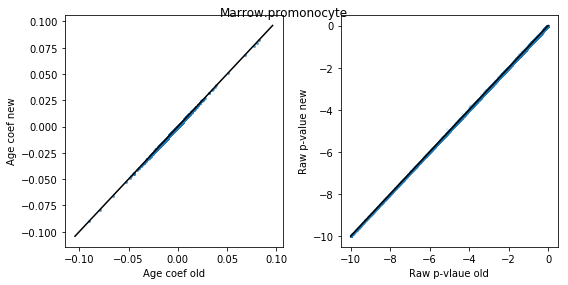

102/131, Pancreas.leukocyte, n_gene=14682, n_gene_old=19842, n_gene_overlap=14512
dif_n_young=0	dif_n_old=0
nan_prop_age=0.2220	nan_prop_raw_p=0.0000
max.r_age_coef=5.1e-02	max.r_raw_p=4.0e-02
q99.dif_age_coef=2.9e-03	q99.dif_raw_p=1.4e-02
q90.dif_age_coef=2.3e-04	q90.dif_raw_p=4.1e-03



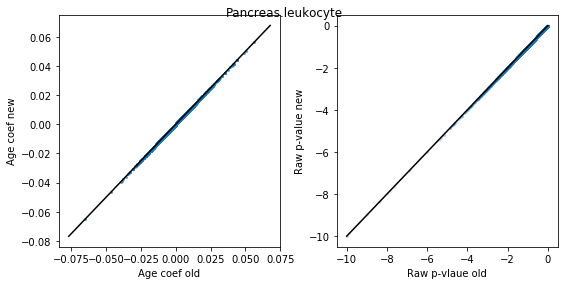

120/131, Spleen.proerythroblast, n_gene=13492, n_gene_old=19842, n_gene_overlap=13394
dif_n_young=0	dif_n_old=0
nan_prop_age=0.2313	nan_prop_raw_p=0.0000
max.r_age_coef=3.0e-01	max.r_raw_p=3.5e-02
q99.dif_age_coef=2.7e-03	q99.dif_raw_p=1.2e-02
q90.dif_age_coef=2.6e-04	q90.dif_raw_p=4.2e-03



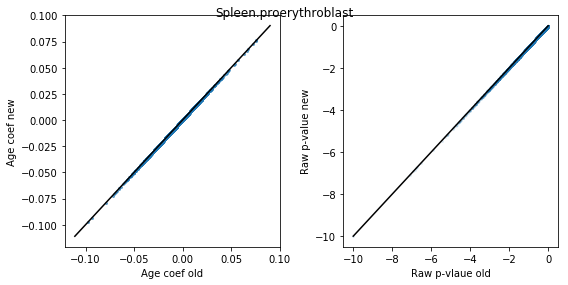

122/131, Thymus.thymocyte, n_gene=21513, n_gene_old=19842, n_gene_overlap=19325
dif_n_young=0	dif_n_old=0
nan_prop_age=0.1419	nan_prop_raw_p=0.0000
max.r_age_coef=8.3e-01	max.r_raw_p=8.8e-02
q99.dif_age_coef=2.9e-03	q99.dif_raw_p=1.6e-02
q90.dif_age_coef=2.8e-04	q90.dif_raw_p=2.7e-03



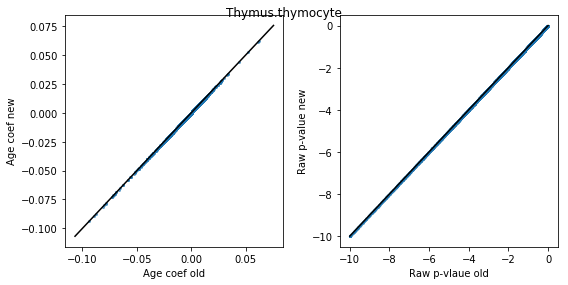

124/131, Tongue.keratinocyte, n_gene=18292, n_gene_old=19842, n_gene_overlap=17711
dif_n_young=0	dif_n_old=0
nan_prop_age=0.1201	nan_prop_raw_p=0.0000
max.r_age_coef=2.4e-01	max.r_raw_p=3.9e-01
q99.dif_age_coef=1.3e-03	q99.dif_raw_p=3.9e-02
q90.dif_age_coef=1.2e-04	q90.dif_raw_p=1.6e-03



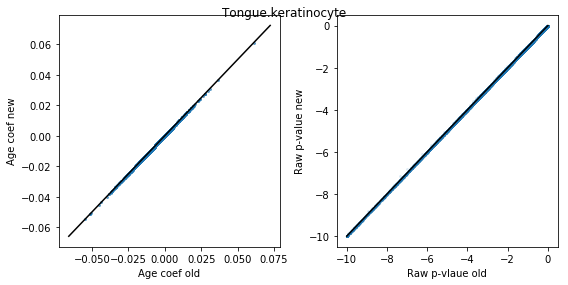

128/131, Trachea.fibroblast, n_gene=19096, n_gene_old=19842, n_gene_overlap=18247
dif_n_young=0	dif_n_old=0
nan_prop_age=0.1268	nan_prop_raw_p=0.0000
max.r_age_coef=2.8e-01	max.r_raw_p=4.9e-01
q99.dif_age_coef=2.4e-03	q99.dif_raw_p=1.1e-01
q90.dif_age_coef=2.6e-04	q90.dif_raw_p=1.2e-02



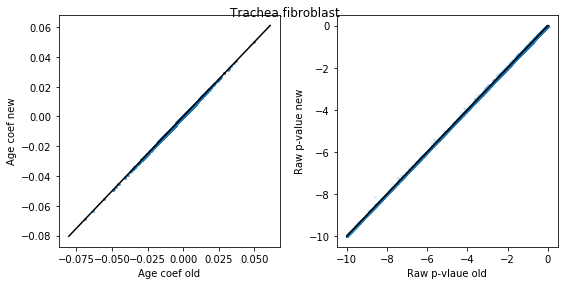

129/131, Trachea.macrophage, n_gene=16701, n_gene_old=19842, n_gene_overlap=16314
dif_n_young=0	dif_n_old=0
nan_prop_age=0.1903	nan_prop_raw_p=0.0000
max.r_age_coef=8.0e-02	max.r_raw_p=2.4e-01
q99.dif_age_coef=1.8e-03	q99.dif_raw_p=5.0e-02
q90.dif_age_coef=1.8e-04	q90.dif_raw_p=7.1e-03



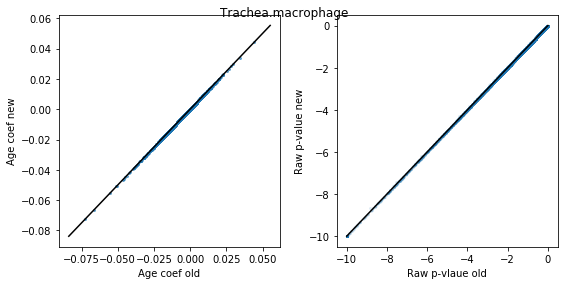

droplet
new reuslt only: {'Spleen.proerythroblast', 'Tongue.basal cell of epidermis', 'Lung.CD4-positive, alpha-beta T cell', 'Lung.CD8-positive, alpha-beta T cell', 'Lung.bronchial smooth muscle cell', 'Limb_Muscle.Schwann cell', 'Lung.adventitial cell', 'Lung.non-classical monocyte', 'Spleen.mature NK T cell', 'Tongue.keratinocyte', 'Lung.NK cell', 'Heart_and_Aorta.endocardial cell', 'Thymus.immature T cell', 'Bladder.leukocyte'}
old reuslt only: {'Lung.mature natural killer T cell', 'Lung.capillary endothelial cell', 'Marrow.nan-marrow-needs-subclustering', 'Lung.natural killer cell', 'Lung.dendritic cell'}

5/57, Heart_and_Aorta.leukocyte, n_gene=14748, n_gene_old=19842, n_gene_overlap=14741
dif_n_young=1	dif_n_old=40
nan_prop_age=0.1406	nan_prop_raw_p=0.0106
max.r_age_coef=6.6e+02	max.r_raw_p=1.1e+02
q99.dif_age_coef=1.6e+01	q99.dif_raw_p=4.4e+00
q90.dif_age_coef=1.6e+00	q90.dif_raw_p=8.7e-01



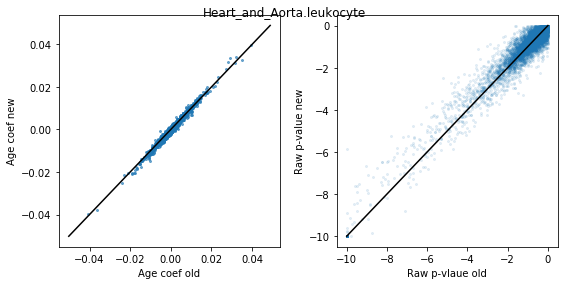

14/57, Kidney.macrophage, n_gene=15371, n_gene_old=19842, n_gene_overlap=15360
dif_n_young=10	dif_n_old=78
nan_prop_age=0.1334	nan_prop_raw_p=0.0056
max.r_age_coef=6.0e+03	max.r_raw_p=1.1e+02
q99.dif_age_coef=1.0e+01	q99.dif_raw_p=4.3e+00
q90.dif_age_coef=1.0e+00	q90.dif_raw_p=8.4e-01



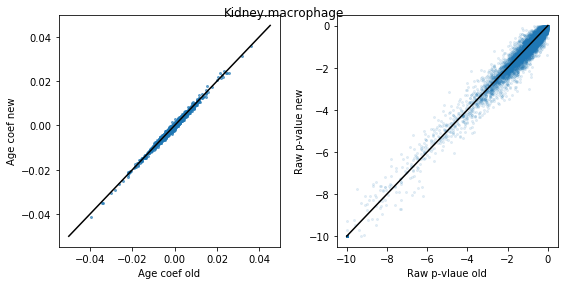

15/57, Kidney.podocyte, n_gene=16070, n_gene_old=19842, n_gene_overlap=16063
dif_n_young=3	dif_n_old=6
nan_prop_age=0.1251	nan_prop_raw_p=0.0094
max.r_age_coef=3.2e+03	max.r_raw_p=4.7e+03
q99.dif_age_coef=2.4e+01	q99.dif_raw_p=1.4e+01
q90.dif_age_coef=2.2e+00	q90.dif_raw_p=1.3e+00



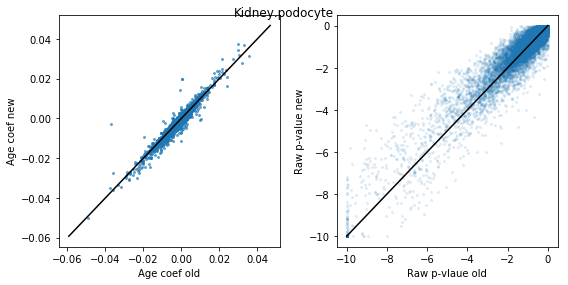

19/57, Limb_Muscle.macrophage, n_gene=16235, n_gene_old=19842, n_gene_overlap=16218
dif_n_young=44	dif_n_old=137
nan_prop_age=0.1197	nan_prop_raw_p=0.0094
max.r_age_coef=6.7e+04	max.r_raw_p=1.0e+03
q99.dif_age_coef=1.8e+01	q99.dif_raw_p=2.5e+01
q90.dif_age_coef=1.7e+00	q90.dif_raw_p=3.6e+00



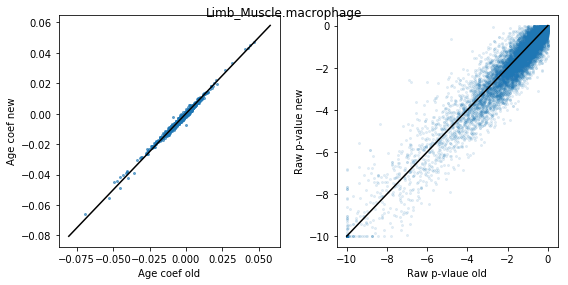

26/57, Liver.hepatocyte, n_gene=14411, n_gene_old=19842, n_gene_overlap=14394
dif_n_young=237	dif_n_old=115
nan_prop_age=0.1262	nan_prop_raw_p=0.0035
max.r_age_coef=1.6e+04	max.r_raw_p=2.5e+03
q99.dif_age_coef=1.9e+01	q99.dif_raw_p=9.9e+00
q90.dif_age_coef=1.8e+00	q90.dif_raw_p=1.0e+00



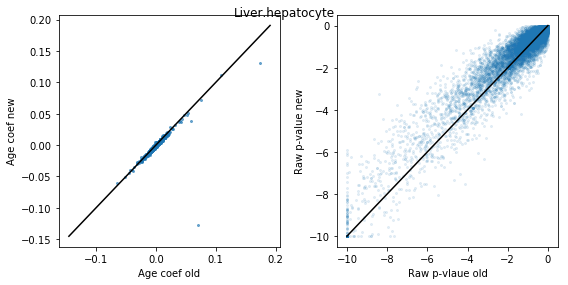

37/57, Mammary_Gland.macrophage, n_gene=14575, n_gene_old=19842, n_gene_overlap=14566
dif_n_young=-1	dif_n_old=-2
nan_prop_age=0.1391	nan_prop_raw_p=0.0000
max.r_age_coef=5.3e+02	max.r_raw_p=2.9e+00
q99.dif_age_coef=2.3e+00	q99.dif_raw_p=5.3e-01
q90.dif_age_coef=1.6e-01	q90.dif_raw_p=1.0e-01



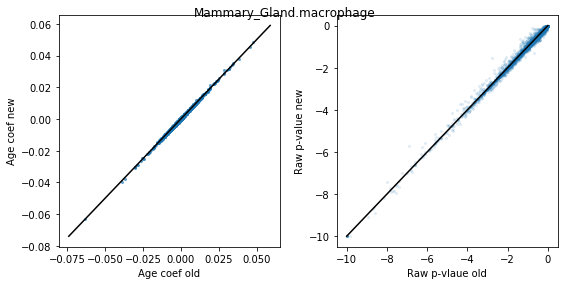

39/57, Marrow.erythroblast, n_gene=13139, n_gene_old=19842, n_gene_overlap=13133
dif_n_young=0	dif_n_old=0
nan_prop_age=0.1384	nan_prop_raw_p=0.0000
max.r_age_coef=9.3e-04	max.r_raw_p=9.6e-05
q99.dif_age_coef=9.9e-06	q99.dif_raw_p=4.2e-05
q90.dif_age_coef=9.9e-07	q90.dif_raw_p=1.6e-05



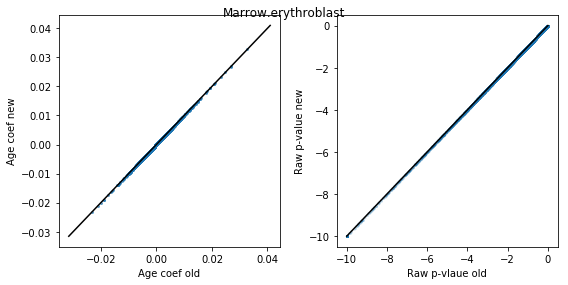

40/57, Marrow.granulocyte, n_gene=14345, n_gene_old=19842, n_gene_overlap=14333
dif_n_young=0	dif_n_old=0
nan_prop_age=0.1368	nan_prop_raw_p=0.0000
max.r_age_coef=4.5e-02	max.r_raw_p=4.1e-04
q99.dif_age_coef=6.4e-05	q99.dif_raw_p=1.7e-04
q90.dif_age_coef=4.9e-06	q90.dif_raw_p=6.0e-05



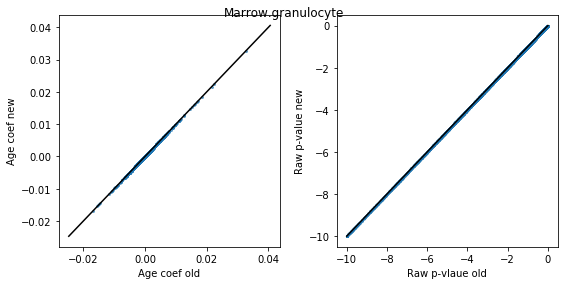

43/57, Marrow.macrophage, n_gene=14124, n_gene_old=19842, n_gene_overlap=14114
dif_n_young=0	dif_n_old=0
nan_prop_age=0.1170	nan_prop_raw_p=0.0000
max.r_age_coef=8.6e-03	max.r_raw_p=3.7e-04
q99.dif_age_coef=9.5e-05	q99.dif_raw_p=5.4e-05
q90.dif_age_coef=8.8e-06	q90.dif_raw_p=1.9e-05



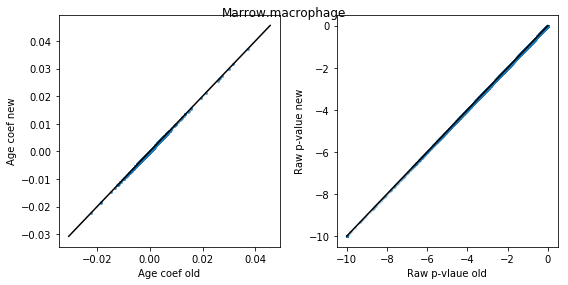

45/57, Marrow.monocyte, n_gene=13765, n_gene_old=19842, n_gene_overlap=13758
dif_n_young=0	dif_n_old=0
nan_prop_age=0.1274	nan_prop_raw_p=0.0000
max.r_age_coef=5.6e-03	max.r_raw_p=8.2e-04
q99.dif_age_coef=6.5e-05	q99.dif_raw_p=5.6e-05
q90.dif_age_coef=5.5e-06	q90.dif_raw_p=1.9e-05



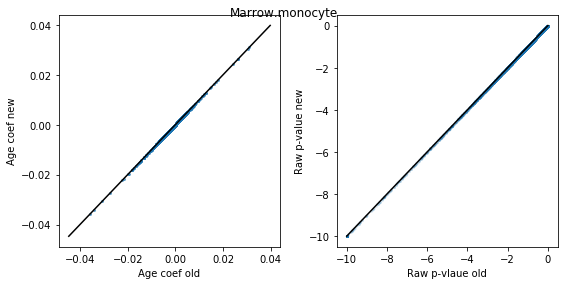

48/57, Marrow.proerythroblast, n_gene=12832, n_gene_old=19842, n_gene_overlap=12827
dif_n_young=0	dif_n_old=0
nan_prop_age=0.1518	nan_prop_raw_p=0.0000
max.r_age_coef=8.7e-04	max.r_raw_p=3.8e-04
q99.dif_age_coef=2.0e-05	q99.dif_raw_p=1.5e-04
q90.dif_age_coef=1.1e-06	q90.dif_raw_p=6.5e-05



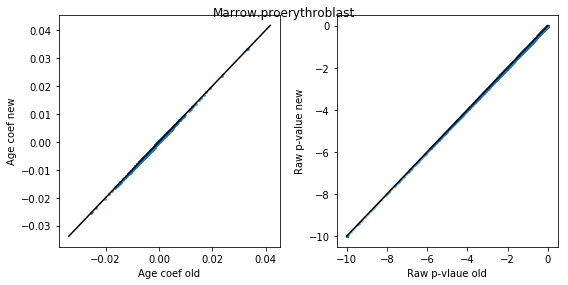

49/57, Marrow.promonocyte, n_gene=14399, n_gene_old=19842, n_gene_overlap=14390
dif_n_young=0	dif_n_old=0
nan_prop_age=0.1124	nan_prop_raw_p=0.0000
max.r_age_coef=2.1e-03	max.r_raw_p=1.2e-04
q99.dif_age_coef=2.6e-05	q99.dif_raw_p=3.9e-05
q90.dif_age_coef=2.0e-06	q90.dif_raw_p=1.3e-05



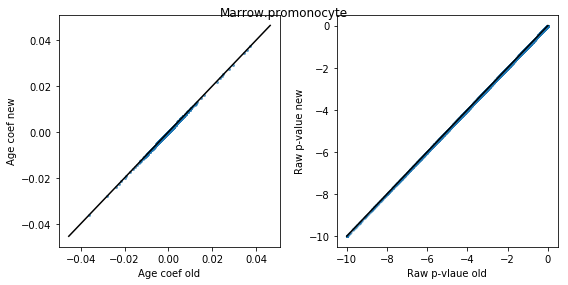

53/57, Spleen.macrophage, n_gene=14663, n_gene_old=19842, n_gene_overlap=14657
dif_n_young=-114	dif_n_old=-310
nan_prop_age=0.1214	nan_prop_raw_p=0.0017
max.r_age_coef=7.4e+03	max.r_raw_p=1.2e+07
q99.dif_age_coef=3.3e+01	q99.dif_raw_p=5.1e+03
q90.dif_age_coef=3.8e+00	q90.dif_raw_p=8.1e+01



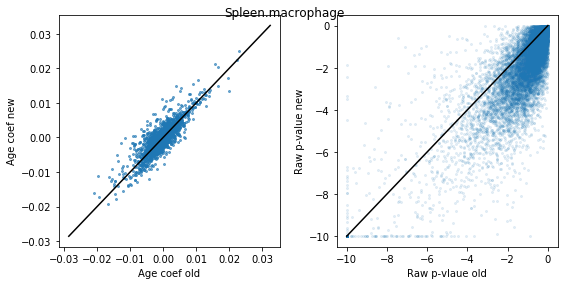

56/57, Thymus.thymocyte, n_gene=13712, n_gene_old=19842, n_gene_overlap=13702
dif_n_young=-169	dif_n_old=-564
nan_prop_age=0.1250	nan_prop_raw_p=0.0024
max.r_age_coef=1.7e+04	max.r_raw_p=2.0e+04
q99.dif_age_coef=3.8e+01	q99.dif_raw_p=3.8e+01
q90.dif_age_coef=3.9e+00	q90.dif_raw_p=3.6e+00



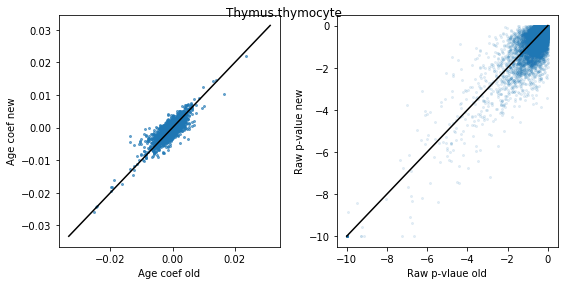

In [10]:
# Compare results on old data and new data
dname_list = ['facs','droplet']
# dname_list = ['facs']
for dname in dname_list:
    print(dname)
    if dname=='facs':
        dname_ = 'FACS'
    else:
        dname_ = dname
    with open(DGE_RES_PATH_OLD+'/DE_tissue_cell_%s.pickle'%dname_, 'rb') as handle:
        dic_res_old = pickle.load(handle)
        analysis_list_old = pickle.load(handle)
        analysis_info_old = pickle.load(handle)
    
    df_info,dic_res = util.load_DGE_res(DATA_PATH, dname='%s.tc'%dname)
    
    # compare
    analysis_list = list(df_info.index)
    print('new reuslt only:', set(analysis_list) - set(analysis_list_old))
    print('old reuslt only:', set(analysis_list_old) - set(analysis_list))
    print('')
    temp_list = list(set(analysis_list) & set(analysis_list_old))
    temp_list.sort()
    
    for i_tissue,tissue in enumerate(temp_list):
        if tissue not in dic_res.keys():
            continue

        n_dif_young = df_info.loc[tissue, 'n_cell_young'] - analysis_info_old[tissue]['n_young']
        n_dif_old = df_info.loc[tissue, 'n_cell_old'] - analysis_info_old[tissue]['n_old']
        
        # comparing the DGE results 
        gene_list = dic_res[tissue].index
        gene_list_old = dic_res_old[tissue].index
        gene_list_common = list(set(gene_list) & set(gene_list_old))
        temp_df = dic_res[tissue].loc[gene_list_common]
        temp_df_old = dic_res_old[tissue].loc[gene_list_common]\
        
        v_coef = np.array(temp_df['age.logFC']) 
        v_nan_coef = np.isnan(v_coef)
        v_coef_old = np.array(temp_df_old['coef']) 
        v_nan_coef_old = np.isnan(v_coef_old)
        ind_select = (~v_nan_coef) & (~v_nan_coef_old)
        v_coef = v_coef[ind_select]
        v_coef_old = v_coef_old[ind_select]
        r_coef = np.absolute(v_coef - v_coef_old)/ (np.absolute(v_coef_old).clip(min=1e-8))
        
        v_raw_p = np.array(temp_df['age.H_p']) 
        v_nan_raw_p = np.isnan(v_raw_p)
        v_raw_p_old = np.array(temp_df_old['raw-p']) 
        v_nan_raw_p_old = np.isnan(v_raw_p_old)
        ind_select = (~v_nan_raw_p) & (~v_nan_raw_p_old)
        v_raw_p = v_raw_p[ind_select]
        v_raw_p_old = v_raw_p_old[ind_select]
        r_raw_p = np.absolute(v_raw_p - v_raw_p_old)/ (np.absolute(v_raw_p_old).clip(min=1e-8))
        
        # print('%d/%d, %s, n_gene=%d, n_gene_old=%d, n_gene_overlap=%d'%
        #       (i_tissue, len(temp_list), tissue, len(gene_list), len(gene_list_old), len(gene_list_common)))
        # print('dif_n_young=%d, dif_n_old=%d'%(n_dif_young, n_dif_old))
        # print('nan_prop_age=%0.4f, nan_prop_raw_p=%0.4f'%
        #       ((v_nan_coef|v_nan_coef_old).sum()/v_nan_coef.shape[0],
        #        (v_nan_raw_p|v_nan_raw_p_old).sum()/v_nan_raw_p.shape[0],))
        # print('max.r_age_coef=%0.1e, max.r_raw_p=%0.1e'%
        #       (r_coef.max(), r_raw_p.max()))
        # print('q99.dif_age_coef=%0.1e, q99.dif_raw_p=%0.1e'%
        #       (np.quantile(r_coef, 0.99), np.quantile(r_raw_p, 0.99)))
        # print('q90.dif_age_coef=%0.1e, q90.dif_raw_p=%0.1e'%
        #       (np.quantile(r_coef, 0.90), np.quantile(r_raw_p, 0.90)))
        # print('')  
        
        print('%d/%d, %s, n_gene=%d, n_gene_old=%d, n_gene_overlap=%d'
              %(i_tissue, len(temp_list), tissue,
                len(gene_list), len(gene_list_old), len(gene_list_common)))
        print('dif_n_young=%d\tdif_n_old=%d'%(n_dif_young,n_dif_old))
        print('nan_prop_age=%0.4f\tnan_prop_raw_p=%0.4f'
              %((v_nan_coef|v_nan_coef_old).sum()/v_nan_coef.shape[0],
               (v_nan_raw_p|v_nan_raw_p_old).sum()/v_nan_raw_p.shape[0],))
        print('max.r_age_coef=%0.1e\tmax.r_raw_p=%0.1e'
              %(r_coef.max(), r_raw_p.max()))
        print('q99.dif_age_coef=%0.1e\tq99.dif_raw_p=%0.1e'
              %(np.quantile(r_coef, 0.99), np.quantile(r_raw_p, 0.99)))
        print('q90.dif_age_coef=%0.1e\tq90.dif_raw_p=%0.1e'
              %(np.quantile(r_coef, 0.90), np.quantile(r_raw_p, 0.90)))
        print('')  
            
        plt.figure(figsize=[8,4])
        
        plt.subplot(121)
        plt.scatter(v_coef_old, v_coef, s=4, alpha=0.6)
        x_min,x_max = plt.xlim()
        y_min,y_max = plt.ylim()
        min_,max_ = min(x_min,y_min), max(x_max,y_max)
        plt.plot([min_, max_], [min_, max_], color='k')
        plt.xlabel('Age coef old')
        plt.ylabel('Age coef new')
        
        
        plt.subplot(122)
        plt.scatter(np.log10(v_raw_p.clip(min=1e-10)), np.log10(v_raw_p_old.clip(min=1e-10)), s=4, alpha=0.1)
        plt.plot([-10, 0], [-10, 0], color='k')
        plt.xlabel('Raw p-vlaue old')
        plt.ylabel('Raw p-value new')
        plt.suptitle(tissue)
        plt.tight_layout()
        plt.show()
